In [174]:
import pandas as pd
from darts import concatenate, TimeSeries
from darts.dataprocessing.transformers import MinTReconciliator  # noqa
from darts.metrics import mae, rmse  # noqa
from darts.models import (
    LinearRegressionModel,
    NaiveSeasonal,
    ExponentialSmoothing 

)
from darts.utils.model_selection import train_test_split
from darts.utils.utils import ModelMode, SeasonalityMode
from darts.utils.likelihood_models import GaussianLikelihood
import matplotlib.pyplot as plt
from tasks_support_system_ai.utils import get_correct_data_path
from tasks_support_system_ai.readers import read_proper_ts_tree, ts_read_daily_tickets
import seaborn as sns
import random

In [175]:
import logging

logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [176]:
df = ts_read_daily_tickets(get_correct_data_path("tickets_daily/tickets_daily.csv"))

In [177]:
df.head()

,queueId,date,new_tickets
0,1,2017-01-01,15
1,1,2017-01-02,26
2,1,2017-01-03,25
3,1,2017-01-04,29
4,1,2017-01-05,26


In [178]:
tree = read_proper_ts_tree(get_correct_data_path("custom_data/tree_proper.csv"))

In [179]:
top_level_tree = tree[(tree["level"] == 1) & (tree["full_load"] != 0)]
top_level_tree.sort_values("full_load", ascending=False)

,queueId,level,immediateDescendants,allDescendants,full_load
7,10,1,"[4472, 472, 4733, 1571, 100118, 2657, 2658, 27...","[10, 104, 462, 472, 1322, 1571, 2190, 2200, 24...",2463146
481,1866,1,"[4307, 4352, 4587, 4667, 4682, 762, 100081, 10...","[762, 1866, 2382, 2733, 3536, 3576, 3617, 3836...",1470013
285,742,1,"[39, 98, 118, 4322, 4412, 2458, 2610, 2921, 3093]","[9, 13, 26, 39, 83, 98, 101, 110, 116, 118, 37...",1387729
26,34,1,"[1, 111, 4522, 842, 1212, 1471, 1531, 1701, 10...","[1, 34, 42, 85, 111, 392, 842, 1212, 1471, 153...",1247019
163,4447,1,"[57, 4457, 4612, 4617, 100254, 100261, 4793, 1...","[57, 382, 1162, 1741, 1881, 1887, 1981, 2007, ...",1121534
485,1871,1,"[4202, 4262, 4723, 100264, 2150, 2170, 2321, 2...","[28, 63, 122, 632, 1062, 1201, 1401, 1871, 198...",1006818
143,4397,1,"[18, 29, 442, 100272, 100042, 2199, 2403, 3750]","[18, 29, 442, 2199, 2240, 2403, 2404, 2535, 32...",986415
90,115,1,"[25, 88, 4547, 4763, 1910, 100044, 100085, 216...","[25, 88, 115, 1910, 2163, 2166, 2219, 2259, 22...",896296
607,2002,1,"[71, 4482, 731, 2226, 2267, 2269, 2298, 2338, ...","[71, 731, 2002, 2226, 2267, 2269, 2298, 2335, ...",825237
41,4147,1,"[7, 14, 4442, 100329, 100034, 100092, 100105, ...","[7, 14, 2544, 3045, 3086, 3095, 3551, 3884, 41...",681754


In [180]:
top_level_queues = list(
    top_level_tree[top_level_tree["full_load"] >= 10_000]["queueId"].values
)
len(top_level_queues), top_level_queues

(19,
 [10,
  34,
  40,
  4147,
  4167,
  115,
  4397,
  4447,
  742,
  1866,
  1871,
  100273,
  2002,
  100322,
  2641,
  2709,
  2922,
  3474,
  3936])

In [181]:
queue_id = 1871


def get_df_slice(queue_id: int):
    queues = tree[tree["queueId"] == queue_id]["allDescendants"].values[0]
    df_slice = df[df["queueId"].isin(queues)].groupby("date")[["new_tickets"]].sum()
    return df_slice


Analyzing Regression...

Analyzing Naive Seasonal...


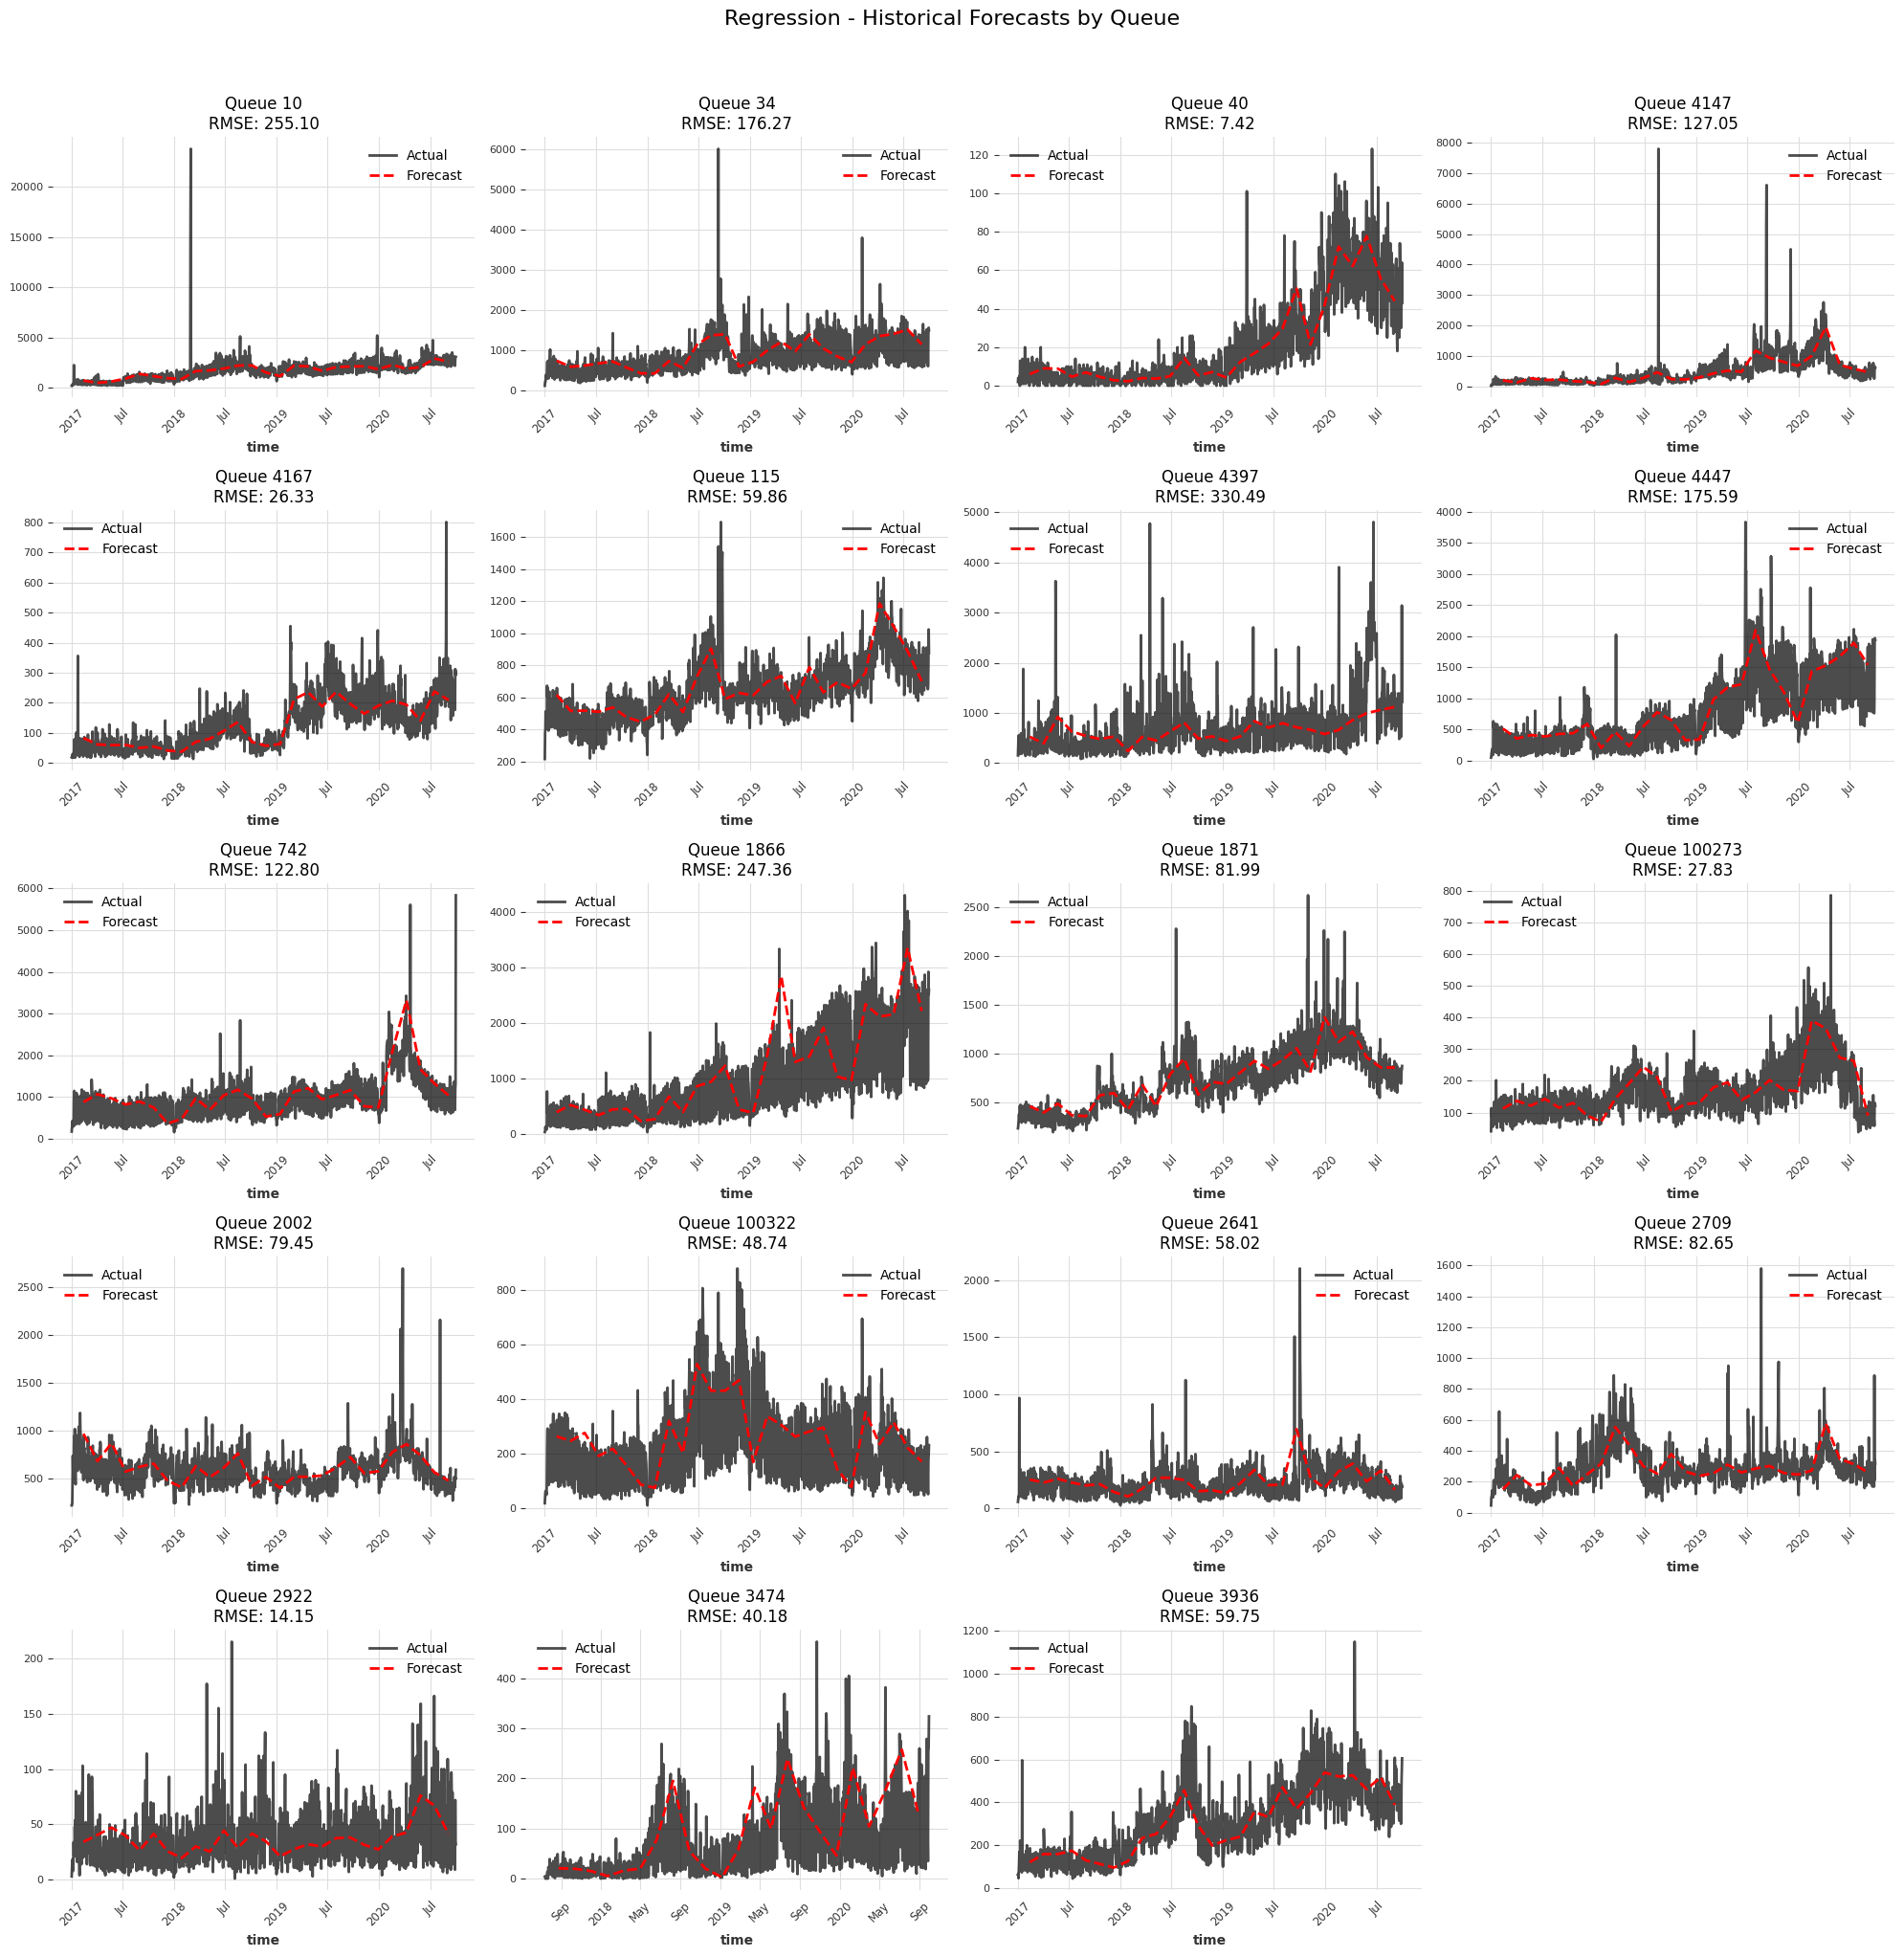

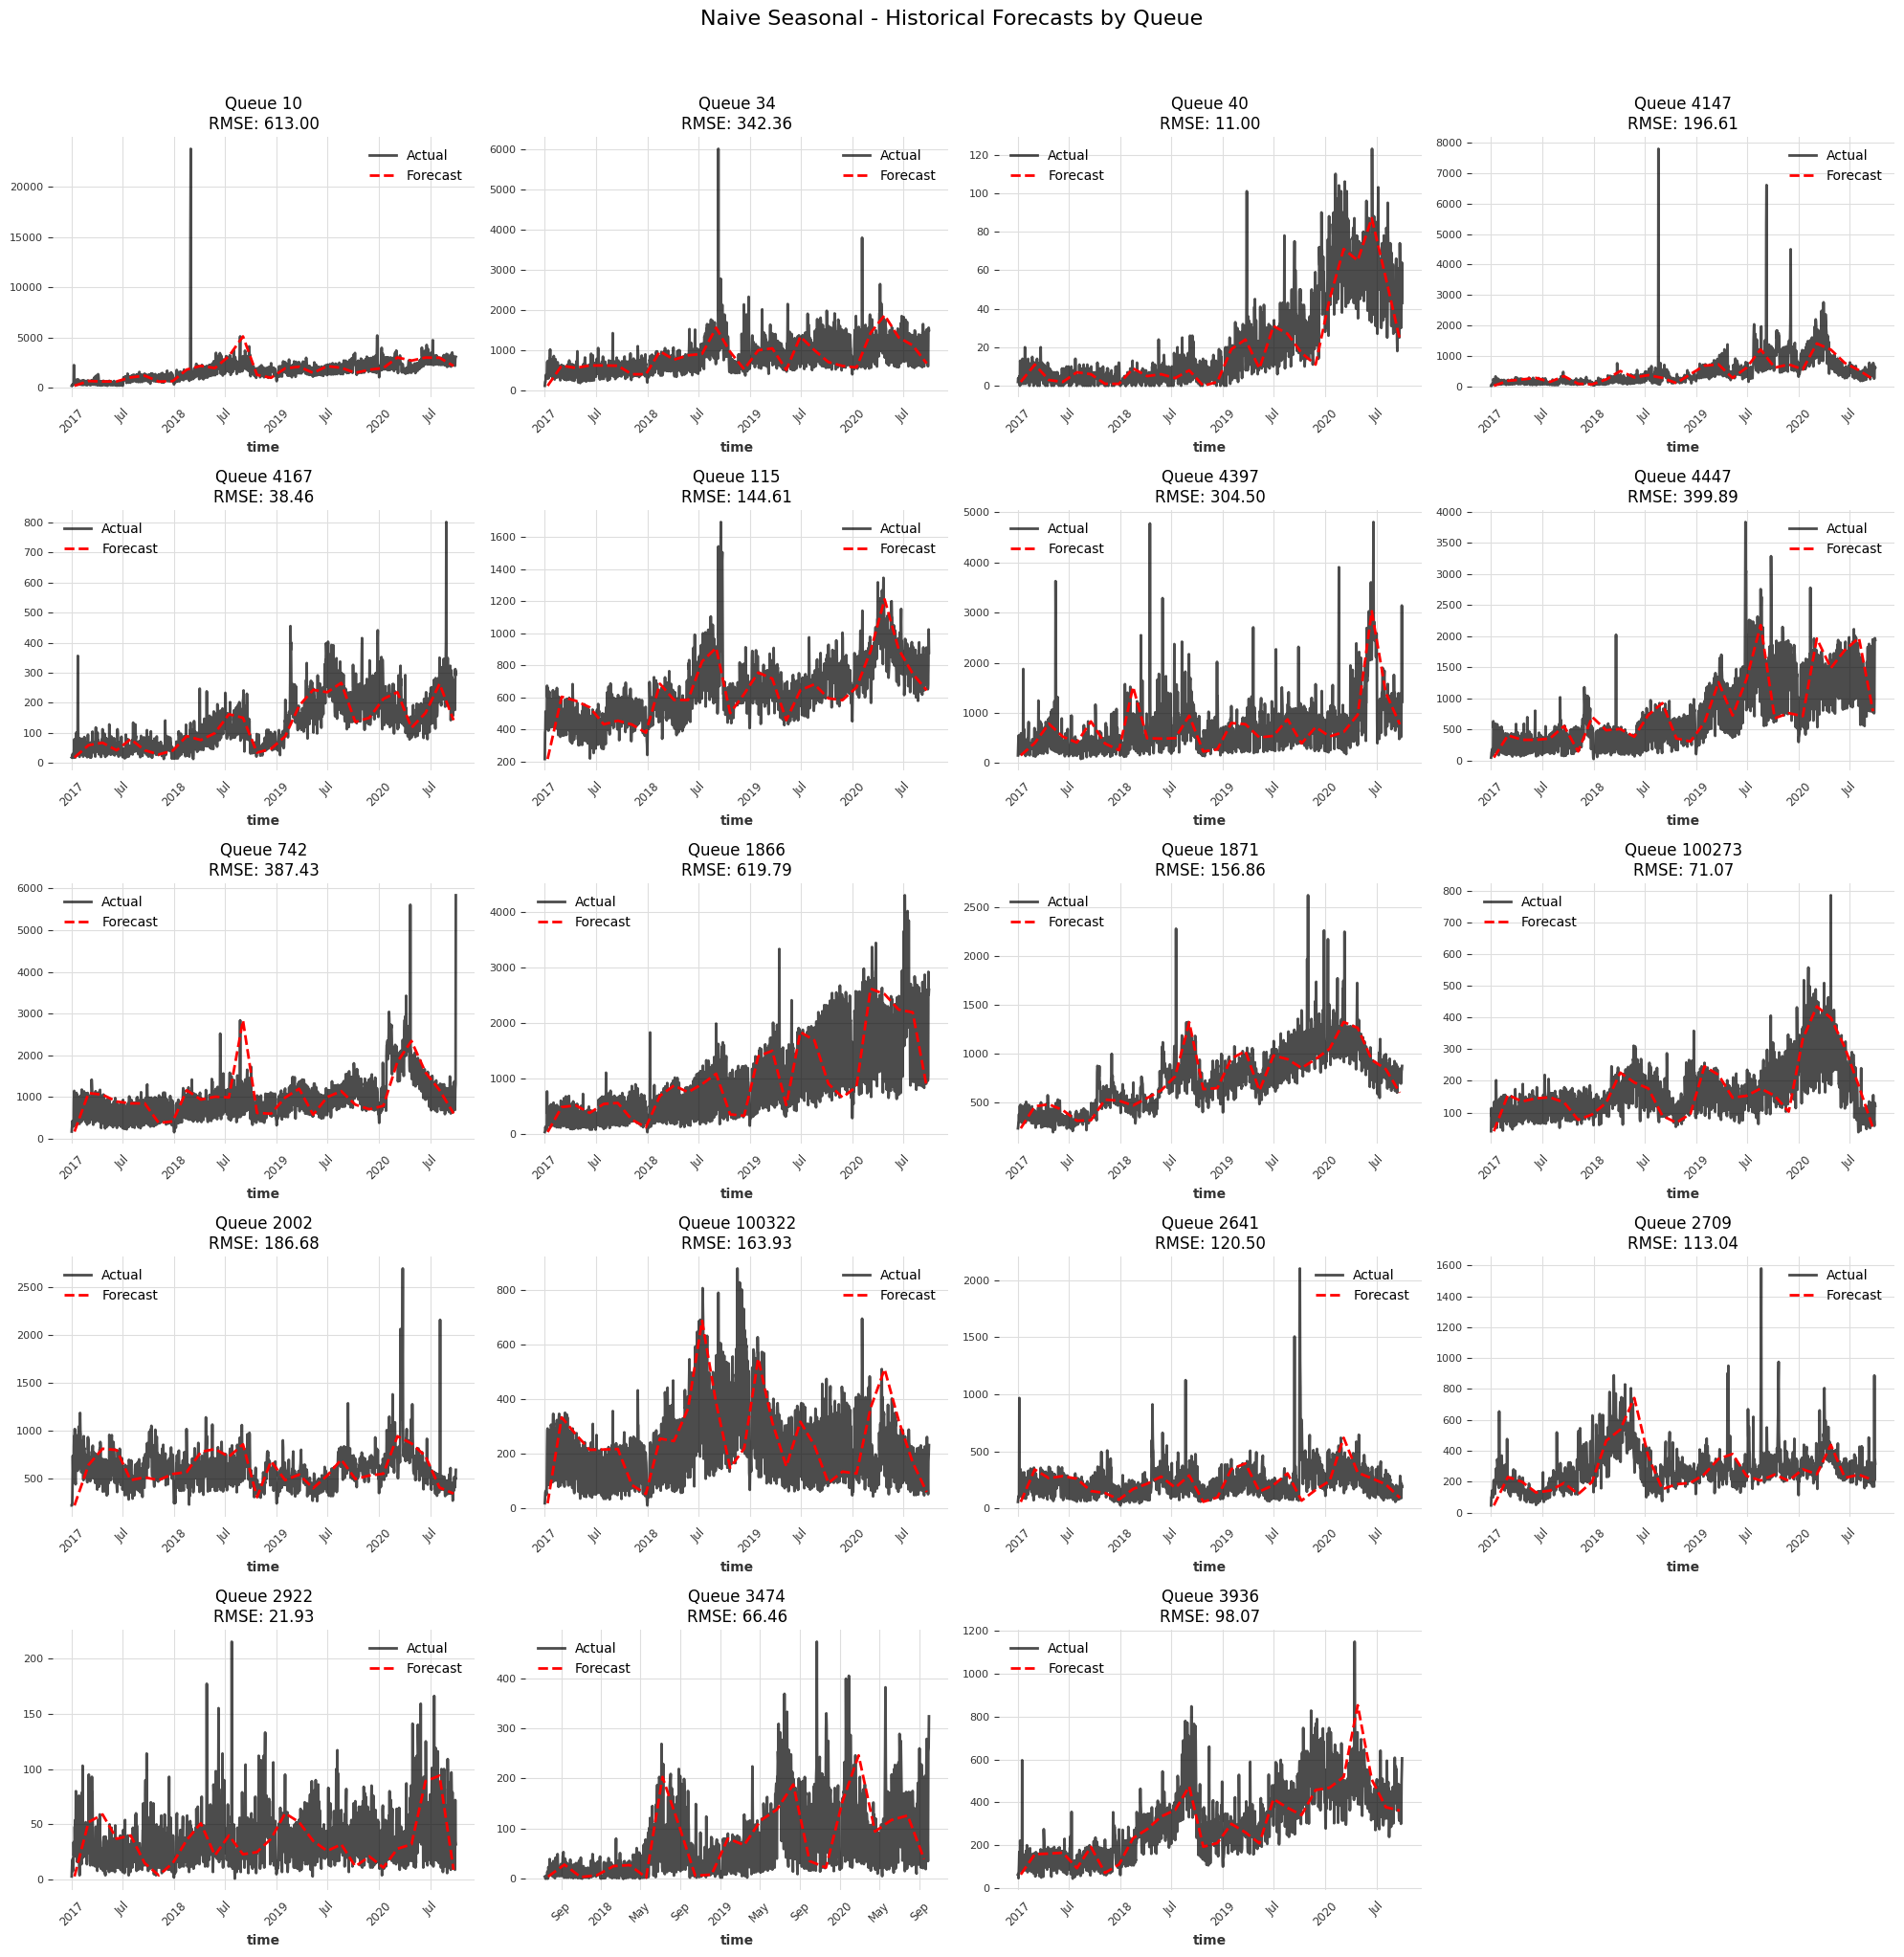

In [182]:
def analyze_queue_performances(
    top_level_queues,
    models_to_try,
    n_predict: int = 10,
    n_cols: int = 4,
):
    results = {model_name: {} for model_name in models_to_try.keys()}

    # Calculate grid dimensions
    n_queues = len(top_level_queues)
    n_rows = (n_queues + n_cols - 1) // n_cols

    for model_name, model_class in models_to_try.items():
        print(f"\nAnalyzing {model_name}...")

        fig = plt.figure(figsize=(5 * n_cols, 4 * n_rows))
        fig.suptitle(
            f"{model_name} - Historical Forecasts by Queue", y=1.02, fontsize=16
        )

        for idx, queue_id in enumerate(top_level_queues):
            df_slice = get_df_slice(queue_id)
            ts = TimeSeries.from_dataframe(
                df_slice,
                value_cols="new_tickets",
                fill_missing_dates=True,
                fillna_value=0,
                freq="D",
            )

            model = model_class
            model.fit(ts)

            # Modifications for Prophet
            if model_name == "Prophet":
                # Use larger stride and fewer forecast points
                stride = max(len(ts) // 10, 30)  # Adjust these numbers as needed
                backtest_rmse = model.backtest(
                    ts,
                    metric=rmse,
                    stride=stride,
                    show_warnings=False,
                    forecast_horizon=7,  # Reduce forecast horizon
                )
                forecasts = model.historical_forecasts(
                    ts, stride=stride, show_warnings=False, forecast_horizon=7
                )
            else:
                # Original settings for other models
                backtest_rmse = model.backtest(
                    ts, metric=rmse, stride=50, show_warnings=False
                )
                forecasts = model.historical_forecasts(
                    ts, stride=50, show_warnings=False
                )

            results[model_name][queue_id] = backtest_rmse

            # Rest of the plotting code remains the same
            ax = plt.subplot(n_rows, n_cols, idx + 1)
            ts.plot(ax=ax, label="Actual", alpha=0.7)
            forecasts.plot(ax=ax, label="Forecast", linestyle="--", color="red")
            ax.set_title(f"Queue {queue_id}\nRMSE: {backtest_rmse:.2f}")
            ax.legend()
            ax.grid(True)
            ax.tick_params(axis="x", rotation=45)
            ax.tick_params(axis="y", labelsize=8)

        plt.tight_layout()

    # Print summary statistics...
    return results


# Define models with optimized parameters for Prophet
models_to_try = {
    "Regression": LinearRegressionModel(lags=10, output_chunk_length=31),
    "Naive Seasonal": NaiveSeasonal(K=10)
}
results = analyze_queue_performances(
    top_level_queues=top_level_queues,
    models_to_try=models_to_try,
    n_predict=10,
    n_cols=4,
)

Здесь эксперименты

<class 'darts.timeseries.TimeSeries'>


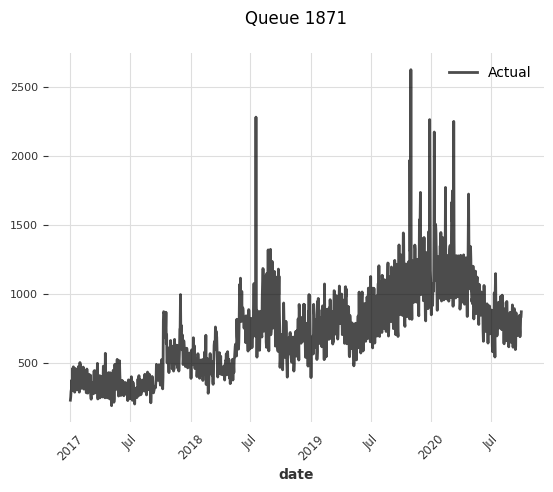

In [183]:
result = get_df_slice(1871)

ts = TimeSeries.from_dataframe(
result,
value_cols="new_tickets",
fill_missing_dates=True,
fillna_value=0,
freq="D",
)

print(type(ts))

ax = plt.subplot()
ts.plot(ax=ax, label="Actual", alpha=0.7)
ax.set_title(f"Queue {queue_id}\n")
ax.legend()
ax.grid(True)
ax.tick_params(axis="x", rotation=45)
ax.tick_params(axis="y", labelsize=8)

In [184]:
X_train, X_test = train_test_split(ts, test_size=0.25)

In [185]:
model = NaiveSeasonal(K=len(X_train))
model.fit(X_train)

NaiveSeasonal(K=1027)

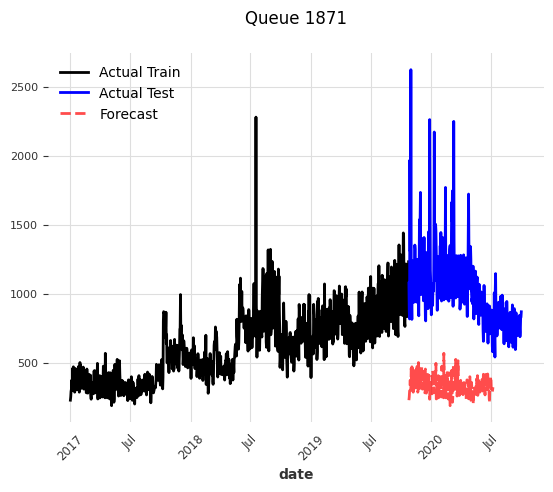

In [186]:
X_pred = model.predict(256)

ax = plt.subplot()
X_train.plot(ax=ax, label="Actual Train")
X_test.plot(ax=ax, label="Actual Test", color='blue')
X_pred.plot(ax=ax, label="Forecast", alpha=0.7, linestyle="--", color="red")
ax.set_title(f"Queue {queue_id}\n")
ax.legend()
ax.grid(True)
ax.tick_params(axis="x", rotation=45)
ax.tick_params(axis="y", labelsize=8)

In [187]:
model = LinearRegressionModel(lags=list(range(-50,-1)), output_chunk_length=200, multi_models=True)
model.fit(X_train)

LinearRegressionModel(lags=[-50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2], lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=200, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True)

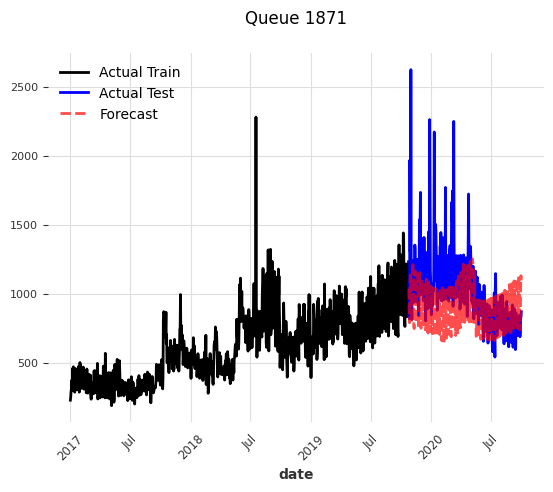

In [188]:
X_pred = model.predict(len(X_test))

ax = plt.subplot()
X_train.plot(ax=ax, label="Actual Train")
X_test.plot(ax=ax, label="Actual Test", color='blue')
X_pred.plot(ax=ax, label="Forecast", alpha=0.7, linestyle="--", color="red")
ax.set_title(f"Queue {queue_id}\n")
ax.legend()
ax.grid(True)
ax.tick_params(axis="x", rotation=45)
ax.tick_params(axis="y", labelsize=8)

<Axes: xlabel='date'>

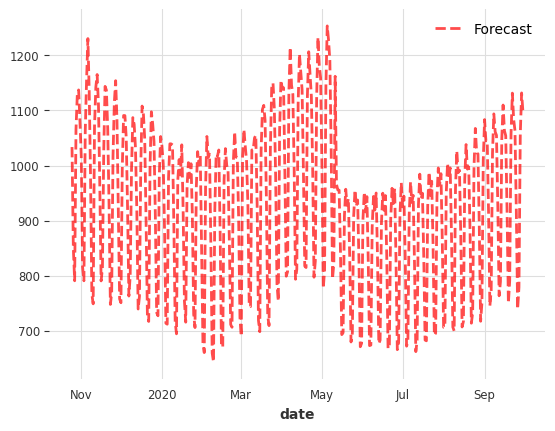

In [189]:
ax = plt.subplot()
X_pred.plot(ax=ax, label="Forecast", alpha=0.7, linestyle="--", color="red")

In [190]:
rmse(X_test, X_pred)

273.4143479826906

In [191]:
mae(X_test, X_pred)

193.06080362430836

С помощью gridSearch находим оптимальные параметры параметров

In [199]:

def grid_search(X_train, X_test):
    num_lists = 10  # Количество списков
    list_size = 50    # Размер каждого списка
    lower_bound = -100  # Нижний предел диапазона
    upper_bound = -1    # Верхний предел диапазона

    random_lags = [
        [random.randint(lower_bound, upper_bound) for _ in range(list_size)] for _ in range(num_lists)
    ]

    param_grid = {
        "lags": random_lags,
        "output_chunk_length": list(range(1, len(X_test))),
        "multi_models": [True, False],
    }
    # Использование gridsearch для подбора гиперпараметров
    grid_search_results = model.gridsearch(
        param_grid,
        X_train,
        metric=rmse,
        n_jobs=-1,  #-1 для максимума
        val_series=X_test,
        verbose=5
    )



    # Лучшие параметры и результат
    return (grid_search_results[1]['lags'])

  0%|          | 0/6820 [00:00<?, ?it/s]


Analyzing Regression...

Analyzing Naive Seasonal...

Analyzing ExponentialSmoothing...


c:\Users\SUBRU\VSCodeProjects\tasks_support_system_ai\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


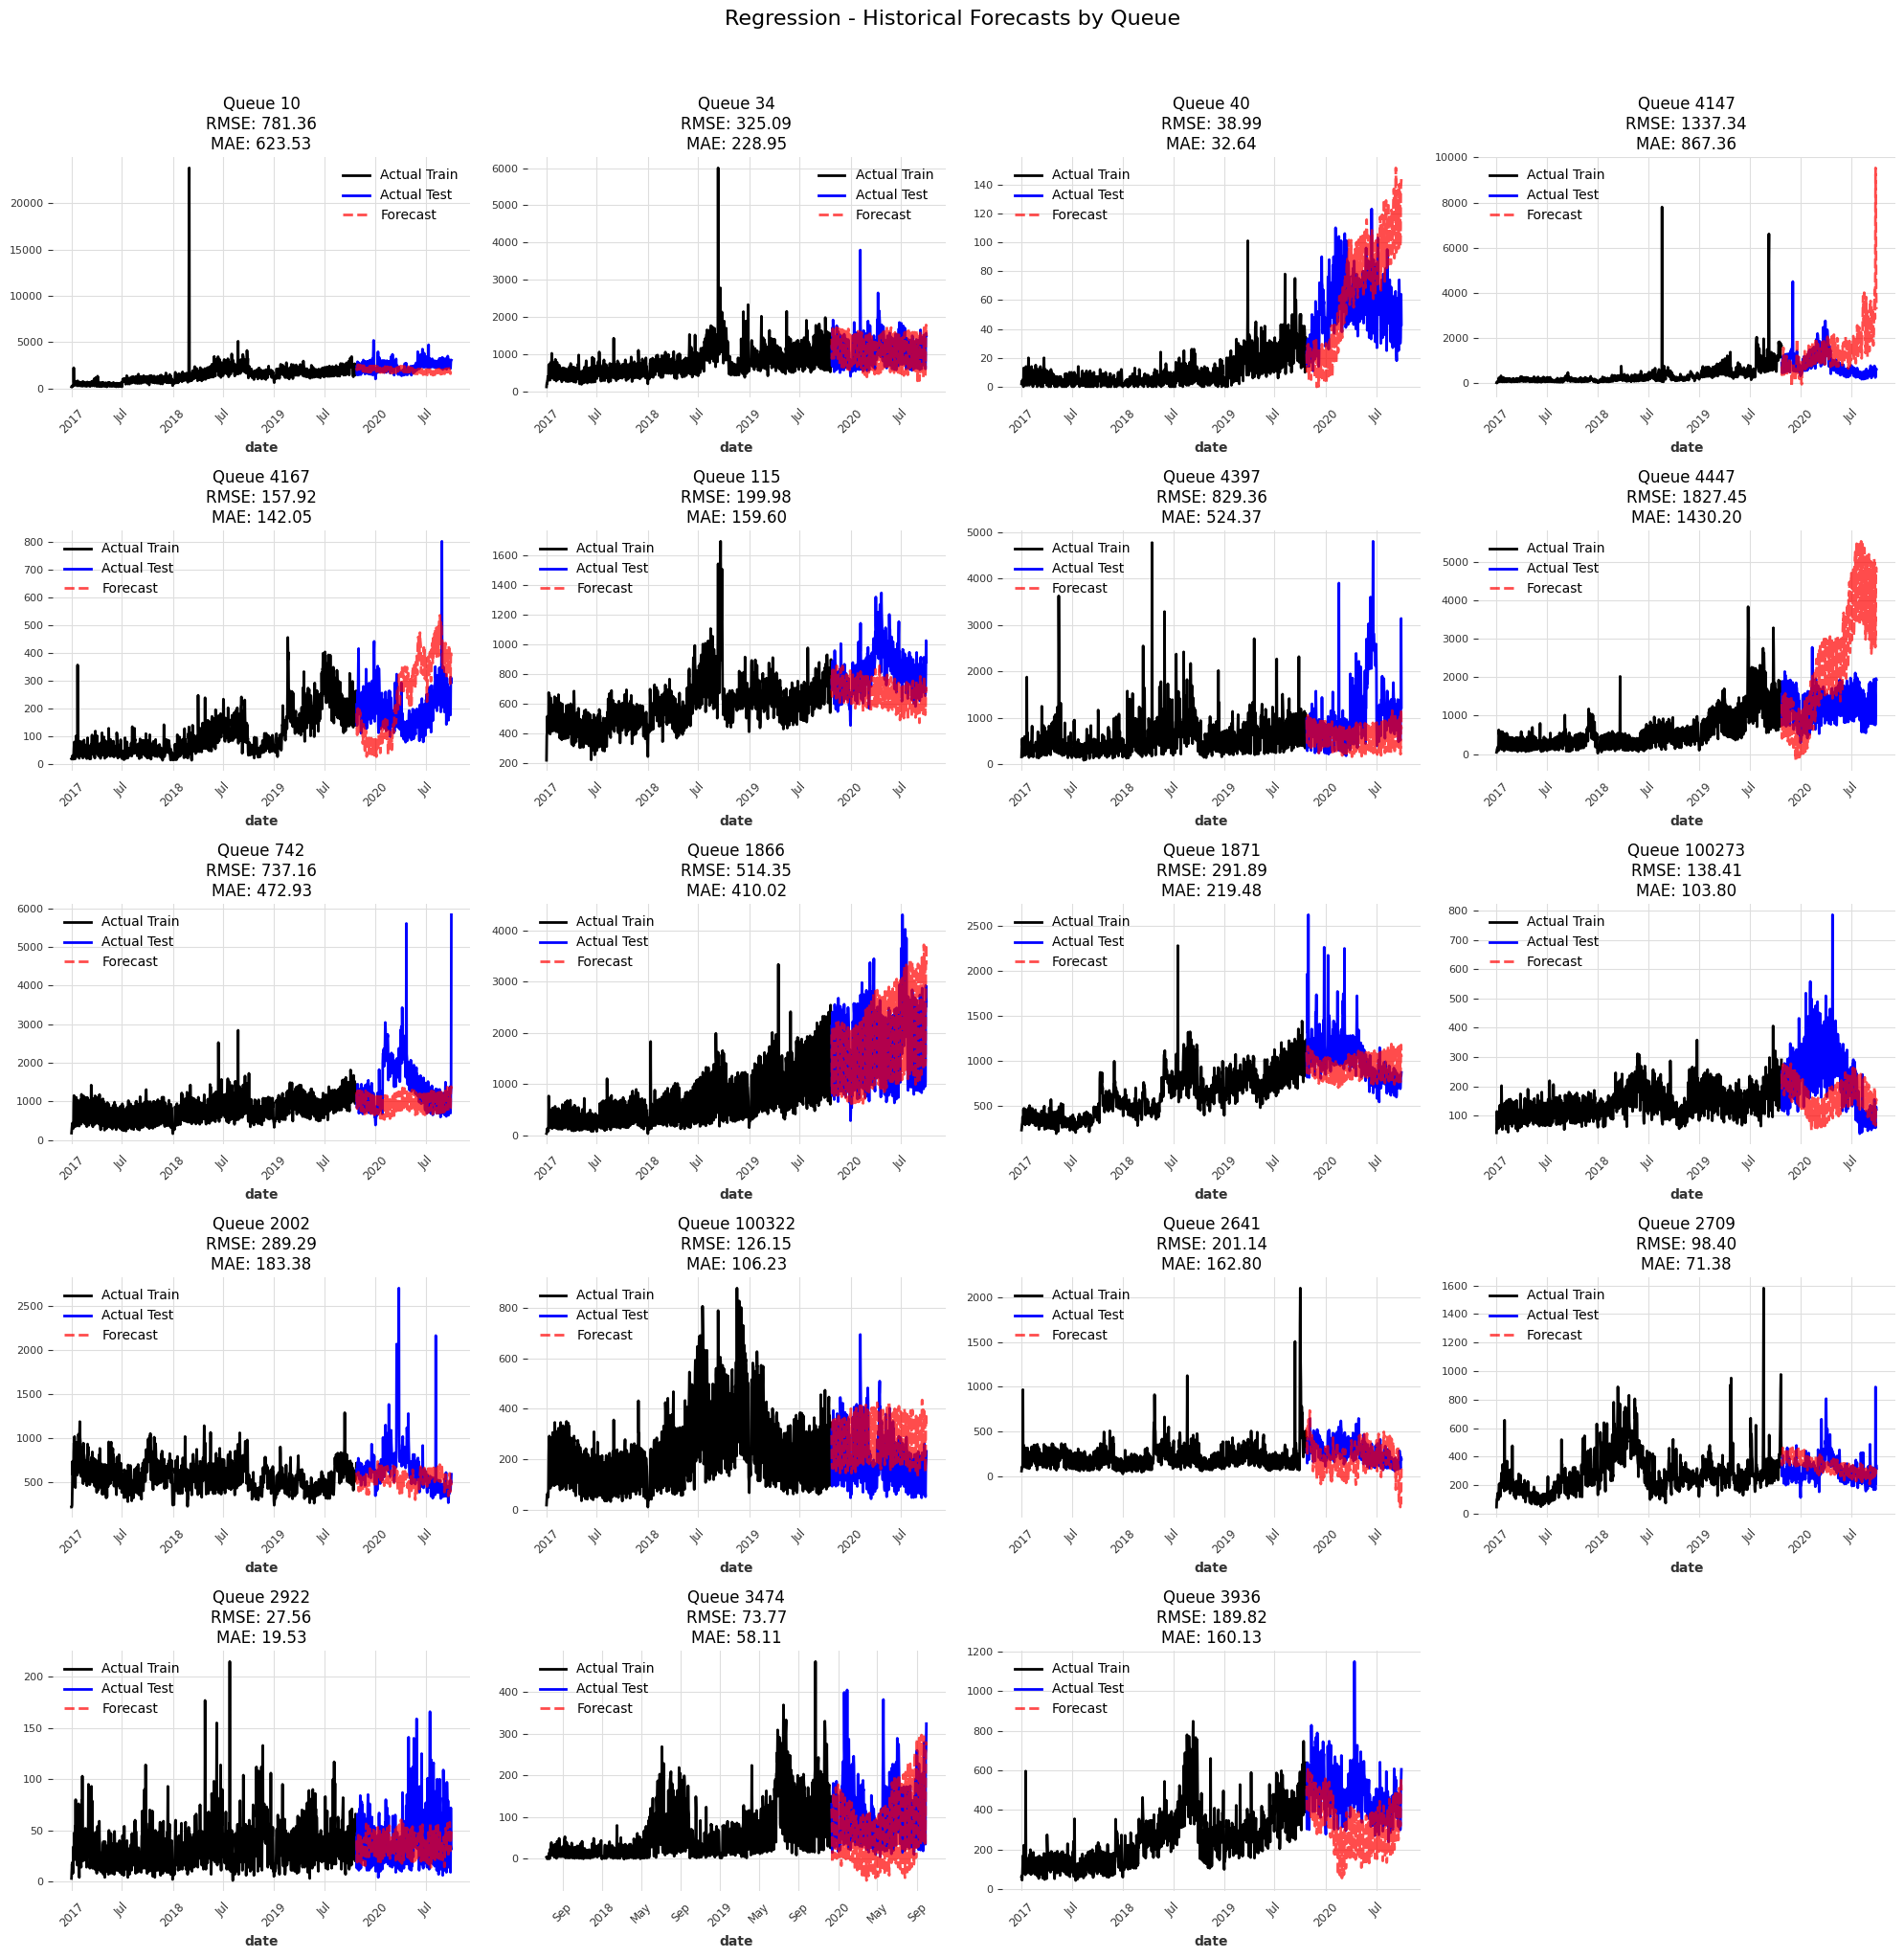

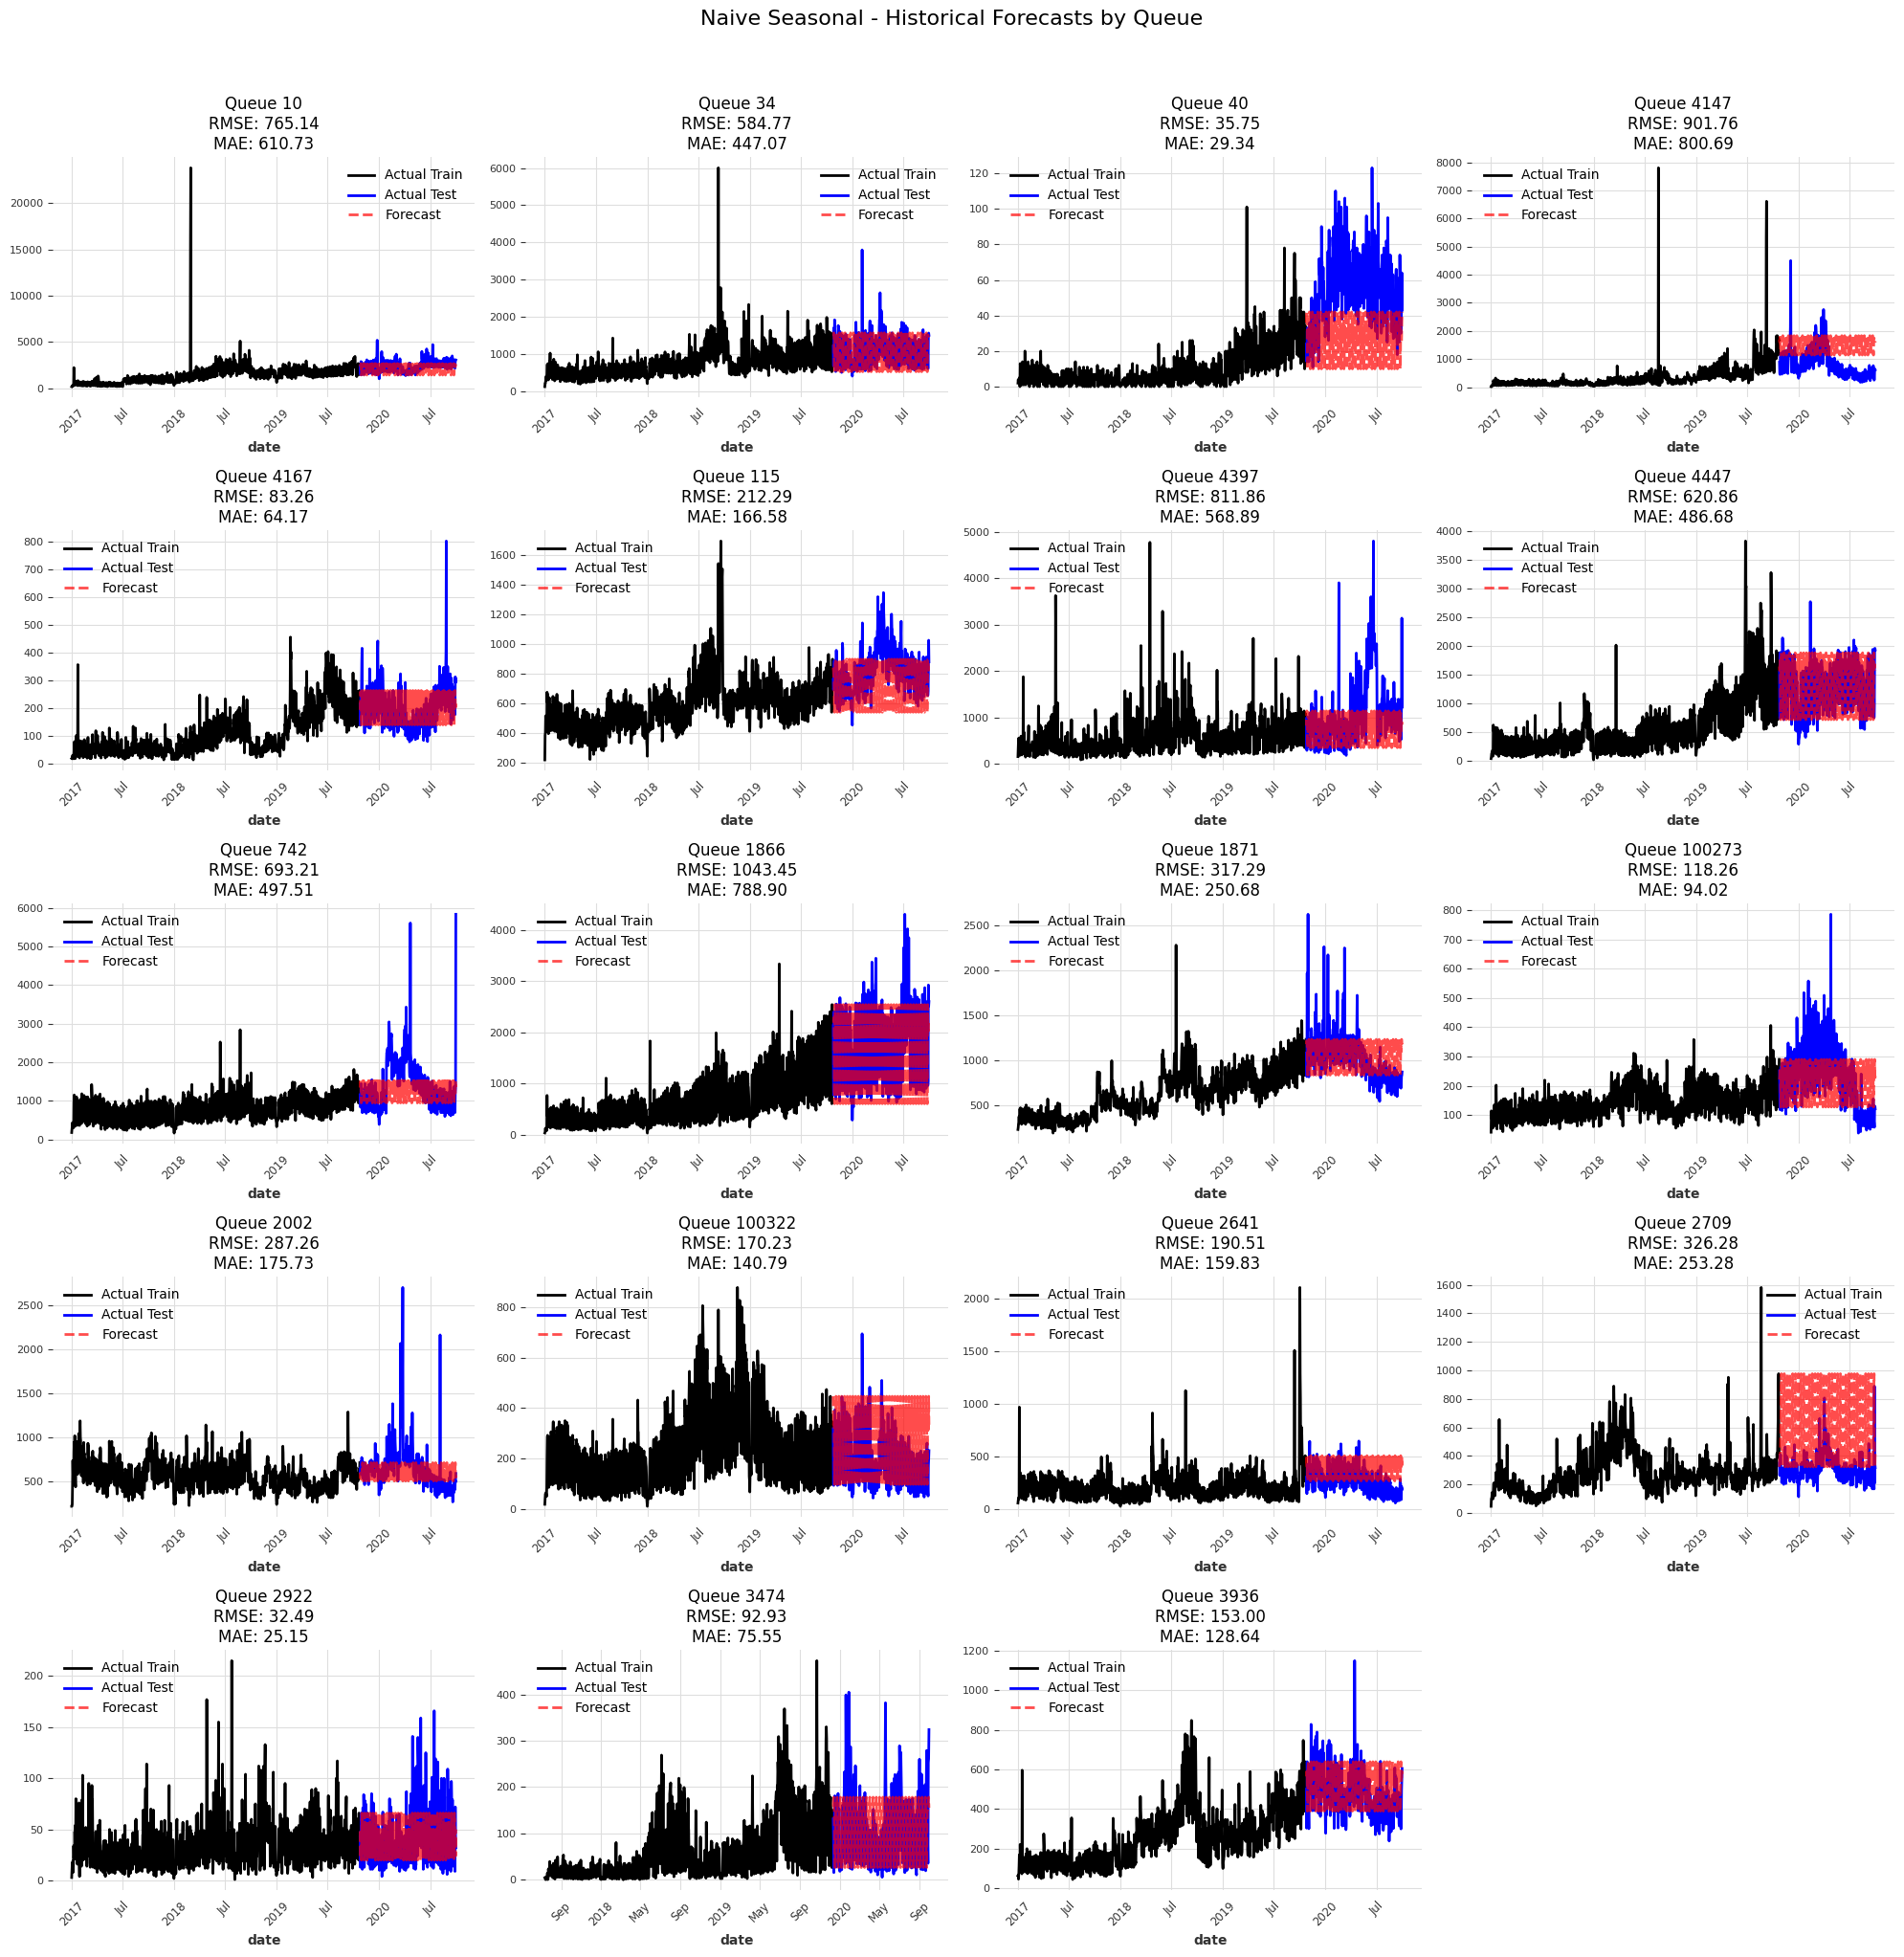

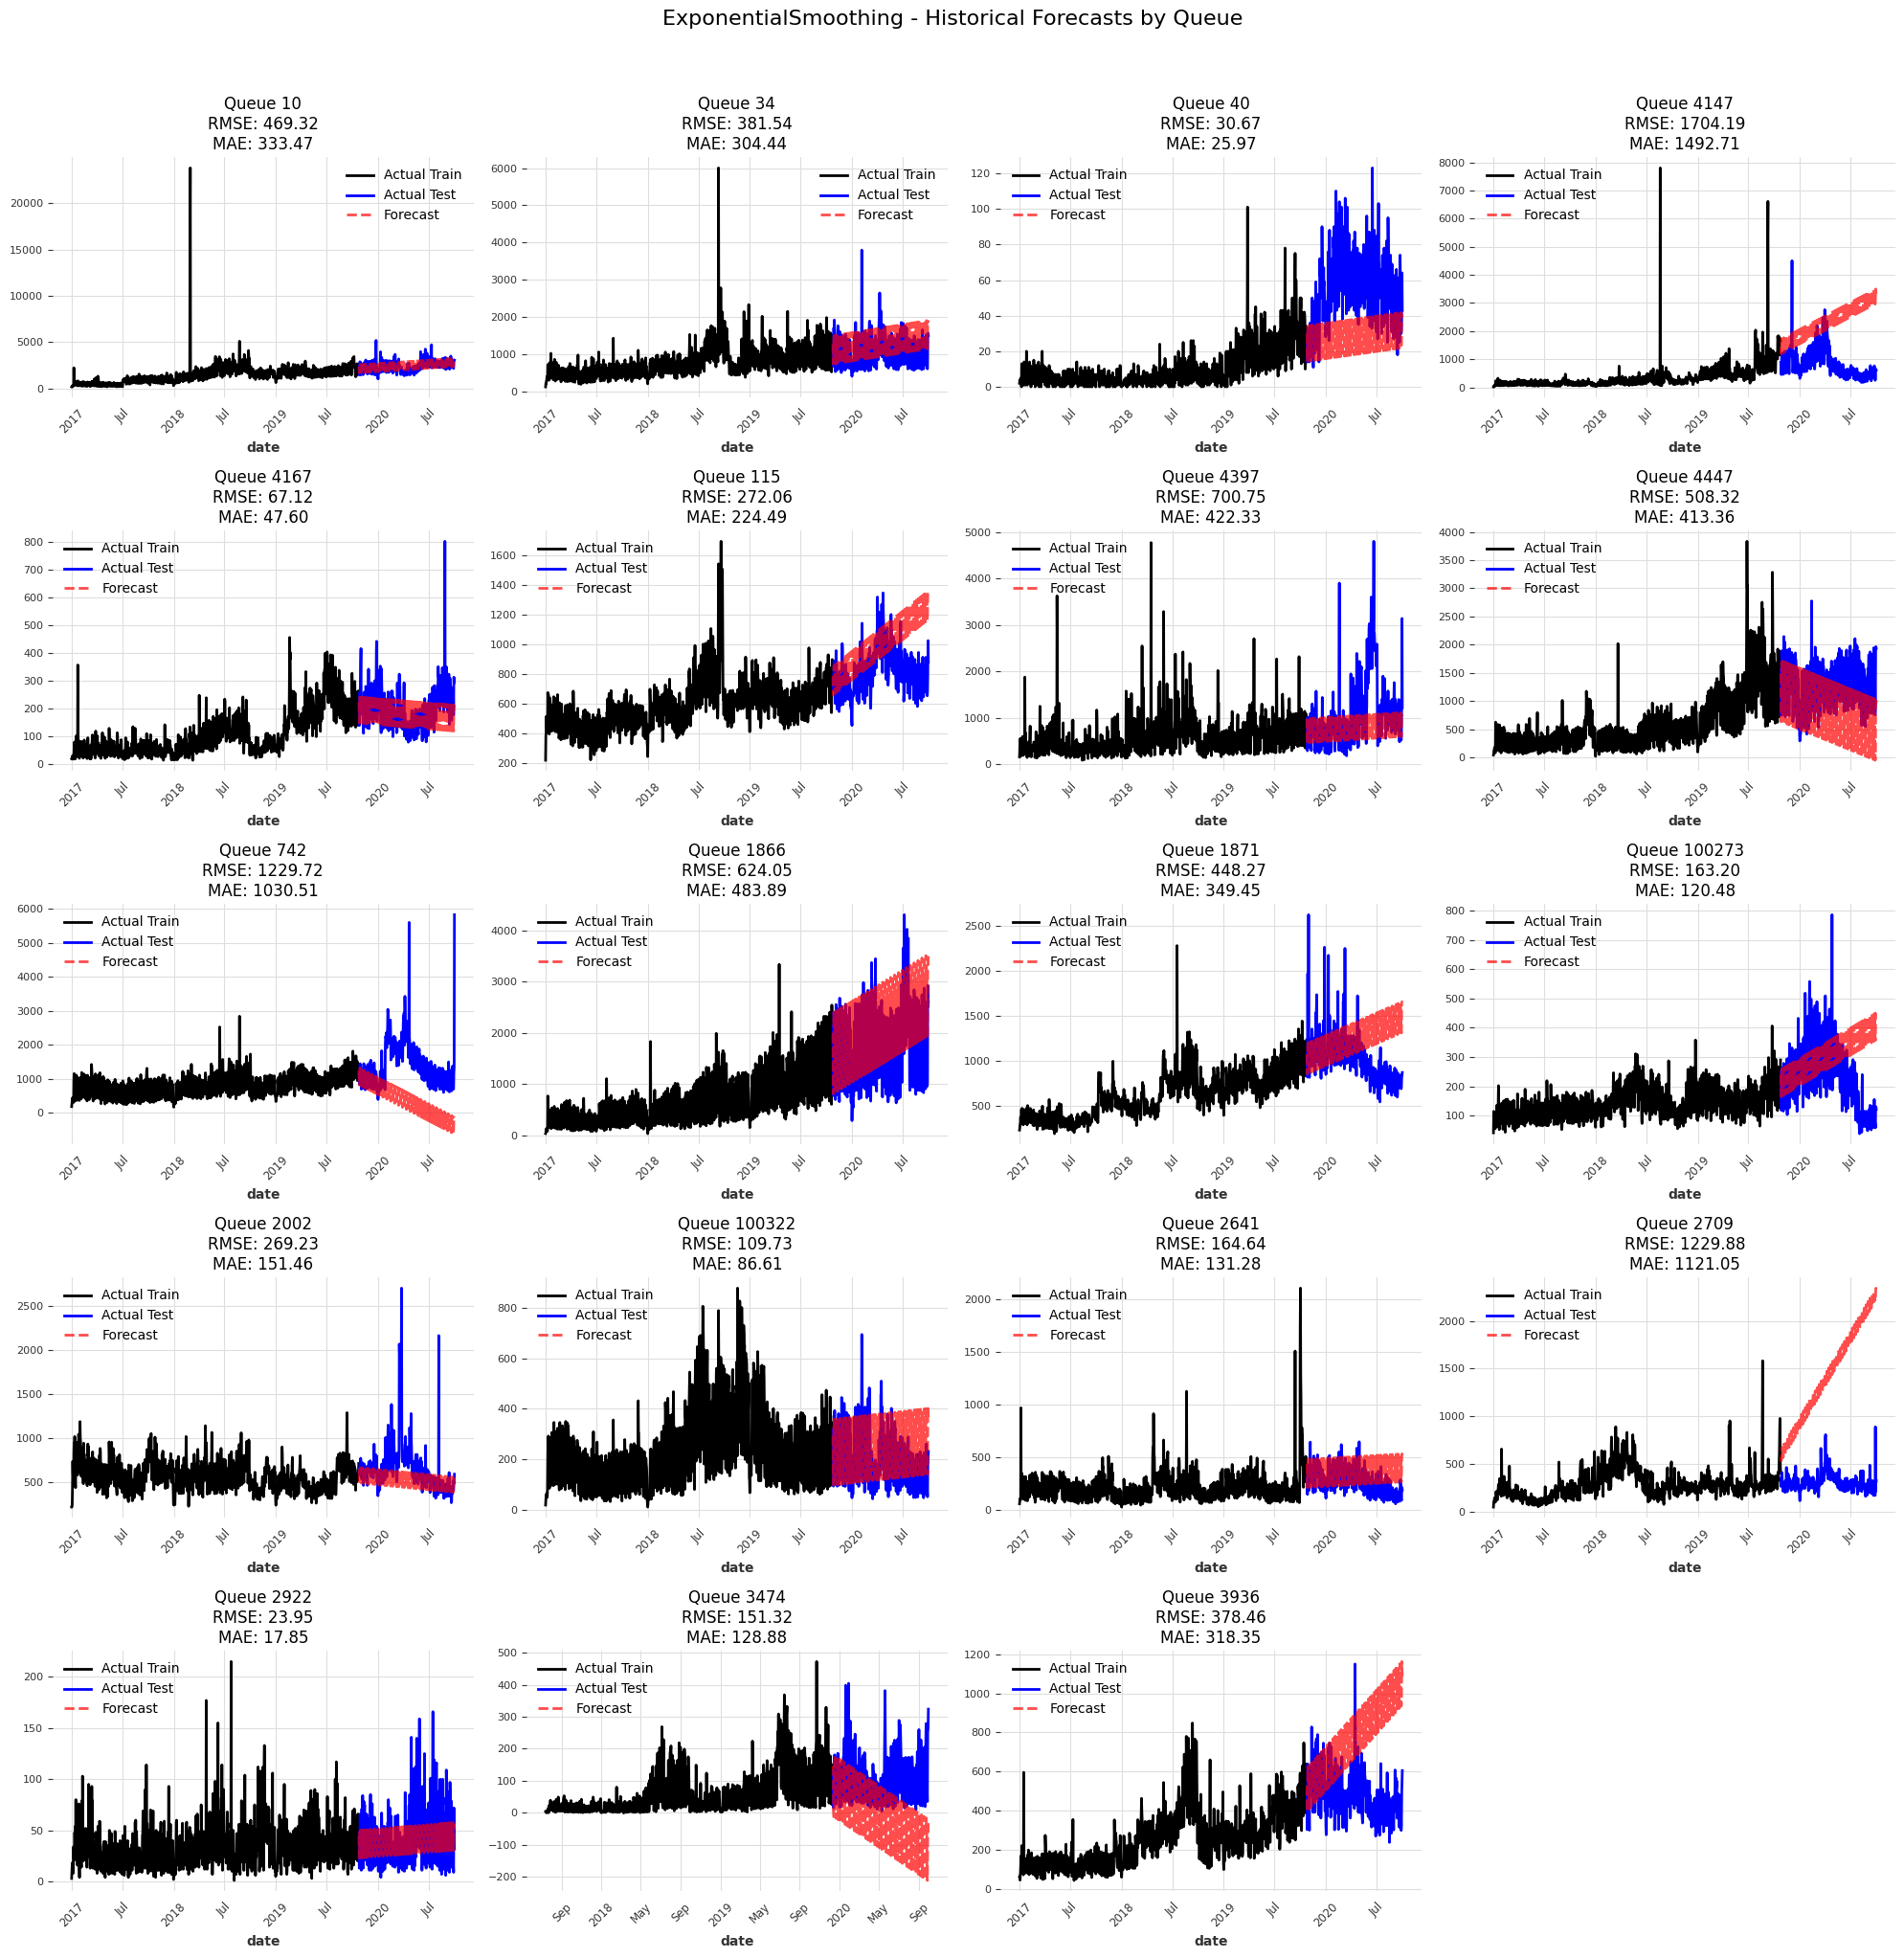

In [200]:
def analyze_queue_performances(
    top_level_queues,
    models_to_try,
    # n_predict: int = 10,
    n_cols: int = 4,
):
    results = {model_name: {} for model_name in models_to_try.keys()}

    # Calculate grid dimensions
    n_queues = len(top_level_queues)
    n_rows = (n_queues + n_cols - 1) // n_cols

    for model_name, model_class in models_to_try.items():
        print(f"\nAnalyzing {model_name}...")

        fig = plt.figure(figsize=(5 * n_cols, 4 * n_rows))
        fig.suptitle(
            f"{model_name} - Historical Forecasts by Queue", y=1.02, fontsize=16
        )

        for idx, queue_id in enumerate(top_level_queues):
            df_slice = get_df_slice(queue_id)
            ts = TimeSeries.from_dataframe(
                df_slice,
                value_cols="new_tickets",
                fill_missing_dates=True,
                fillna_value=0,
                freq="D",
            )
            X_train, X_test = train_test_split(ts, test_size=0.25)
            model = model_class
            model.fit(X_train)
            X_pred = model.predict(len(X_test))
            # Modifications for Prophet
            if model_name == "Prophet":
                # Use larger stride and fewer forecast points
                stride = max(len(ts) // 10, 30)  # Adjust these numbers as needed
                backtest_rmse = model.backtest(
                    ts,
                    metric=rmse,
                    stride=stride,
                    show_warnings=False,
                    forecast_horizon=7,  # Reduce forecast horizon
                )
                forecasts = model.historical_forecasts(
                    ts, stride=stride, show_warnings=False, forecast_horizon=7
                )
            else:
                # Original settings for other models
                RMSE_score = rmse(X_pred, X_test)
                MAE_score = mae(X_pred, X_test)
                

            results[model_name][queue_id] = RMSE_score

            # Rest of the plotting code remains the same
            ax = plt.subplot(n_rows, n_cols, idx + 1)
            X_train.plot(ax=ax, label="Actual Train")
            X_test.plot(ax=ax, label="Actual Test", color='blue')
            X_pred.plot(ax=ax, label="Forecast", alpha=0.7, linestyle="--", color="red")
            ax.set_title(f"Queue {queue_id}\nRMSE: {RMSE_score:.2f}\nMAE: {MAE_score:.2f}")
            ax.legend()
            ax.grid(True)
            ax.tick_params(axis="x", rotation=45)
            ax.tick_params(axis="y", labelsize=8)

        plt.tight_layout()

    # Print summary statistics...
    return results


# Define models with optimized parameters for Prophet
models_to_try = {
    "Regression": LinearRegressionModel(lags=grid_search(X_train, X_test), 
                                        output_chunk_length=len(X_test), multi_models=True),
    "Naive Seasonal": NaiveSeasonal(K=10),
    "ExponentialSmoothing": ExponentialSmoothing(trend=ModelMode.ADDITIVE, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7)
}
results = analyze_queue_performances(
    top_level_queues=top_level_queues,
    models_to_try=models_to_try,
    # n_predict=10,
    n_cols=4,
)